In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.cluster import KMeans
from statsmodels.tsa.stattools import grangercausalitytests
import warnings
warnings.filterwarnings('ignore')

In [2]:
def load_and_process_data(file_path):
    df = pd.read_csv(file_path)
    df.set_index(pd.to_datetime(df['time']), inplace=True)
    #df.drop(['Unnamed: 0','time'], axis = 1, inplace=True)
    return df

In [3]:
df = load_and_process_data('../data/merged_data/ADA.csv')
df.head()

,Unnamed: 0,time,BTC_open,BTC_close,BTC_volume,ADA_open,ADA_close,ADA_volume
time,,,,,,,,
2016-12-10 03:00:00,0,2016-12-10 03:00:00,774.14,773.22,300299.79,0.0,0.0,0.0
2016-12-10 04:00:00,1,2016-12-10 04:00:00,773.22,774.38,445496.69,0.0,0.0,0.0
2016-12-10 05:00:00,2,2016-12-10 05:00:00,774.38,772.83,531621.78,0.0,0.0,0.0
2016-12-10 06:00:00,3,2016-12-10 06:00:00,772.83,774.44,361825.55,0.0,0.0,0.0
2016-12-10 07:00:00,4,2016-12-10 07:00:00,774.44,770.87,334746.86,0.0,0.0,0.0


In [4]:
def calculate_percentage_change(df, ticker, hours):
    df.loc[:, f'{ticker}_open'] = df.loc[:, f'{ticker}_open'].replace(0, np.nan).ffill()
    df.loc[:, f'{ticker}_close'] = df.loc[:, f'{ticker}_close'].replace(0, np.nan).ffill()
    for ticker in ['BTC',ticker]:
        df[f'perc_{ticker}_change_1hr'] = ((df[f'{ticker}_close']-df[f'{ticker}_open'])/df[f'{ticker}_open'])*100
        for i in np.arange(1,hours + 1):
            df[f'perc_{ticker}_change_{i}hr'] = (df[f'{ticker}_close'].diff(i)/df[f'{ticker}_close'].shift(i)) * 100
    df = df.dropna()[hours:]
    
    return df


In [5]:
df = calculate_percentage_change(df, 'ADA',6)

In [6]:
def perform_clustering(df, ticker):
    X = df[[f'perc_{ticker}_change_6hr' for ticker in ['BTC',ticker]]]
    X.dropna(inplace=True)
    km = KMeans(n_clusters=5, random_state=42)
    km.fit(X)
    return km, X

In [7]:
km, X = perform_clustering(df, 'ADA')

In [8]:
def visualize_clusters(km, X):
    y_pred = km.predict(X)
    plt.figure(figsize=(10, 7))
    for i in range(km.n_clusters):
        cluster_i = X[y_pred == i]
        plt.scatter(cluster_i.iloc[:, 0], cluster_i.iloc[:, 1], label=f'Cluster {i}')
    plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], s=300, c='red', label = 'Centroids')
    plt.title('Clusters')
    plt.xlabel('perc_BTC_change_6hr') 
    plt.ylabel('perc_ETH_change_6hr') 
    plt.legend()
    plt.show()


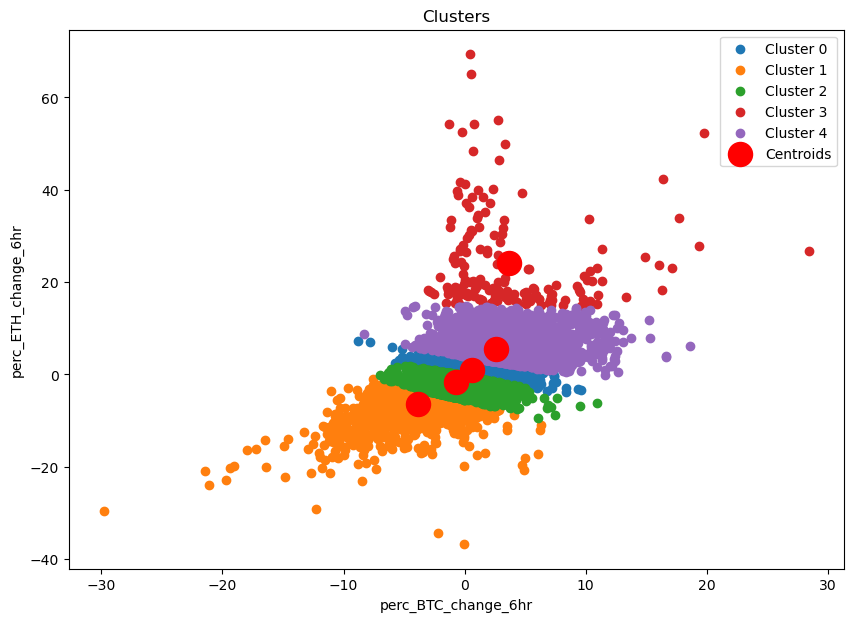

In [9]:
visualize_clusters(km, X)

In [10]:
def perform_granger_causality_tests(df, ticker):
    maxlag=7
    test_result = grangercausalitytests(df[['perc_BTC_change_1hr', f'perc_{ticker}_change_1hr']], maxlag=maxlag)
    return test_result

In [11]:
test_result = perform_granger_causality_tests(df, 'ADA')
test_result


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2893  , p=0.2562  , df_denom=50963, df_num=1
ssr based chi2 test:   chi2=1.2894  , p=0.2562  , df=1
likelihood ratio test: chi2=1.2894  , p=0.2562  , df=1
parameter F test:         F=1.2893  , p=0.2562  , df_denom=50963, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.5866  , p=0.2046  , df_denom=50960, df_num=2
ssr based chi2 test:   chi2=3.1735  , p=0.2046  , df=2
likelihood ratio test: chi2=3.1734  , p=0.2046  , df=2
parameter F test:         F=1.5866  , p=0.2046  , df_denom=50960, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.2283  , p=0.0054  , df_denom=50957, df_num=3
ssr based chi2 test:   chi2=12.6866 , p=0.0054  , df=3
likelihood ratio test: chi2=12.6851 , p=0.0054  , df=3
parameter F test:         F=4.2283  , p=0.0054  , df_denom=50957, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.6075  

{1: ({'ssr_ftest': (1.2892942641698955, 0.2561833894226318, 50963.0, 1),
   'ssr_chi2test': (1.2893701600706962, 0.25616405457419766, 1),
   'lrtest': (1.2893538507196354, 0.25616706188220495, 1),
   'params_ftest': (1.289294264174079, 0.2561833894217012, 50963.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (1.5865732012437261, 0.20463572997265764, 50960.0, 2),
   'ssr_chi2test': (3.1734577394578687, 0.20459377119833555, 2),
   'lrtest': (3.1733589420909993, 0.20460387811090341, 2),
   'params_ftest': (1.5865732012463116, 0.2046357299716534, 50960.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (4.228298572207198, 0.005373679652964641, 50957.0, 3),
   'ssr_chi2test': (12.686638249934317, 0.005365686235923717, 3),
   'lrtest': (12.685059448398533, 0.0053696326286769925, 3),
   'params_ftest': (4.228298572207066, 0.005373679652964641, 50957.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],


In [12]:
def find_windows_after_rise(df, threshold):
    def get_next_6hr_window(df, index):
        if index+6 < len(df):
            return df.iloc[index:index+6]
        else:
            return None
    windows_after_rise = pd.DataFrame()
    i = 0
    while i < len(df) - 1:
        if df['perc_BTC_change_1hr'].iloc[i] > threshold:
            window = get_next_6hr_window(df, i)
            if window is not None:
                windows_after_rise = windows_after_rise.append(window)
                i += 6  # Skip ahead 6 indices after finding a window
                continue
        i += 1
    return windows_after_rise

In [13]:
windows_after_rise = find_windows_after_rise(df, 5)
windows_after_rise.head(50)

,Unnamed: 0,time,BTC_open,BTC_close,BTC_volume,ADA_open,ADA_close,ADA_volume,perc_BTC_change_1hr,perc_BTC_change_2hr,perc_BTC_change_3hr,perc_BTC_change_4hr,perc_BTC_change_5hr,perc_BTC_change_6hr,perc_ADA_change_1hr,perc_ADA_change_2hr,perc_ADA_change_3hr,perc_ADA_change_4hr,perc_ADA_change_5hr,perc_ADA_change_6hr
time,,,,,,,,,,,,,,,,,,,,
2017-11-12 07:00:00,8104,2017-11-12 07:00:00,5616.67,6138.88,1.715678e+08,0.02275,0.02541,741474.38,9.296918,5.205359,2.219092,1.160260,-0.743589,-0.903652,11.692308,4.182042,0.993641,0.673534,-3.089245,-5.044843
2017-11-12 08:00:00,8105,2017-11-12 08:00:00,6138.00,6175.41,1.396754e+08,0.02541,0.02458,365510.25,0.595060,9.947300,5.831394,2.827356,1.762223,-0.152954,-3.266431,8.043956,0.779008,-2.305246,-2.614897,-6.254767
2017-11-12 09:00:00,8106,2017-11-12 09:00:00,6175.39,6219.36,7.858173e+07,0.02458,0.02450,1374286.11,0.711694,1.310988,10.729788,6.584589,3.559172,2.486459,-0.325468,-3.581267,7.692308,0.451005,-2.623211,-2.931854
2017-11-12 10:00:00,8107,2017-11-12 10:00:00,6219.88,6377.67,5.312607e+07,0.02451,0.02577,337627.06,2.545439,3.275248,3.889797,13.548347,9.297635,6.195207,5.183673,4.841334,1.416765,13.274725,5.658057,2.424483
2017-11-12 11:00:00,8108,2017-11-12 11:00:00,6377.73,6380.07,6.764612e+07,0.02589,0.02539,321666.81,0.037631,2.584028,3.314112,3.928893,13.591077,9.338765,-1.474583,3.632653,3.295362,-0.078709,11.604396,4.100041
2017-11-12 12:00:00,8109,2017-11-12 12:00:00,6380.07,6194.60,5.023504e+07,0.02527,0.02379,304579.27,-2.907021,-2.870484,-0.398112,0.310749,0.907657,10.288960,-6.301694,-7.683353,-2.897959,-3.213995,-6.375443,4.571429
2017-11-29 21:00:00,8526,2017-11-29 21:00:00,9509.08,10194.60,1.320960e+08,0.09007,0.10630,151671.81,7.199302,6.645215,-1.740595,-3.808648,-6.029640,-6.164053,18.019318,10.786868,-0.468165,15.581168,15.468173,-8.911740
2017-11-29 22:00:00,8527,2017-11-29 22:00:00,10194.32,9998.52,1.054366e+08,0.10630,0.09845,88562.38,-1.923371,5.137461,4.594031,-3.630488,-5.658764,-7.837039,-7.384760,9.303875,2.605524,-7.818352,7.045776,6.941125
2017-11-29 23:00:00,8528,2017-11-29 23:00:00,10000.65,9837.86,8.123488e+07,0.09848,0.08993,59062.03,-1.606838,-3.499304,3.448073,2.913375,-5.178989,-7.174675,-8.654139,-15.399812,-0.155435,-6.274101,-15.795880,-2.218115


In [14]:
def find_lag_times(windows_after_rise, threshold, ticker):
    lag_times = []
    met_thresholds = []
    for i in range(0, len(windows_after_rise), 6):
        window = windows_after_rise.iloc[i:i+6]
        for i in np.arange(1,6):
            window_itr = window[window[f'perc_{ticker}_change_{i}hr'] > threshold][f'perc_{ticker}_change_{i}hr']
            if window_itr.empty == False: 
                rise_time = window_itr.idxmax()
                lag_time = rise_time - window.index[0]
                met_threshold = int(1)
            else:
                lag_time = timedelta(0)
                met_threshold = int(0)
        lag_times.append(lag_time)
        met_thresholds.append(met_threshold)
        
        for a in range(5):
            lag_times.append(None)
            met_thresholds.append(None)
    lag_times_df = pd.DataFrame({
        'lag_time': lag_times,
        'met_threshold': met_thresholds
    })
    return lag_times_df


In [16]:
lag_times_df = find_lag_times(windows_after_rise, 3, 'ADA')
lag_times_df.shape

(330, 2)

In [16]:
lag_times_df.index = windows_after_rise.index
target_df = windows_after_rise.join(lag_times_df, how='left')

In [17]:
csv_files = {
    "ADA": "../data/merged_data/ADA.csv",
    "BNB": "../data/merged_data/BNB.csv",
    "DOGE": "../data/merged_data/DOGE.csv",
    "DOT": "../data/merged_data/DOT.csv",
    "ETH": "../data/merged_data/ETH.csv",
    "LINK": "../data/merged_data/LINK.csv",
    "LTC": "../data/merged_data/LTC.csv",
    "UNI": "../data/merged_data/UNI.csv",
    "XRP": "../data/merged_data/XRP.csv"
}

In [18]:
df.head()

,Unnamed: 0,time,BTC_open,BTC_close,BTC_volume,ADA_open,ADA_close,ADA_volume,perc_BTC_change_1hr,perc_BTC_change_2hr,perc_BTC_change_3hr,perc_BTC_change_4hr,perc_BTC_change_5hr,perc_BTC_change_6hr,perc_ADA_change_1hr,perc_ADA_change_2hr,perc_ADA_change_3hr,perc_ADA_change_4hr,perc_ADA_change_5hr,perc_ADA_change_6hr
time,,,,,,,,,,,,,,,,,,,,
2017-10-02 08:00:00,7118,2017-10-02 08:00:00,4429.25,4455.32,10550053.54,0.02082,0.02183,1815251.80,0.588587,0.145431,0.082666,0.685653,0.915307,0.977748,4.851105,-3.407080,-3.662842,-8.315834,-14.021268,-9.381486
2017-10-02 09:00:00,7119,2017-10-02 09:00:00,4455.32,4469.21,12824593.59,0.02183,0.02311,2366625.00,0.311762,0.902184,0.457646,0.394686,0.999553,1.229923,5.863491,10.999039,2.256637,1.985878,-2.939941,-8.979913
2017-10-02 10:00:00,7120,2017-10-02 10:00:00,4469.21,4468.55,9121505.80,0.02311,0.02234,1060223.63,-0.014768,0.296948,0.887283,0.442811,0.379860,0.984637,-3.331891,2.336235,7.300672,-1.150442,-1.412180,-6.173877
2017-10-02 11:00:00,7121,2017-10-02 11:00:00,4468.55,4398.38,22324319.97,0.02234,0.02226,1347161.93,-1.570308,-1.584844,-1.278023,-0.696958,-1.134450,-1.196413,-0.358102,-3.678061,1.969766,6.916427,-1.504425,-1.765225
2017-10-02 12:00:00,7122,2017-10-02 12:00:00,4398.38,4394.66,24289231.36,0.02226,0.02189,1069908.50,-0.084577,-1.653557,-1.668080,-1.361518,-0.780945,-1.218068,-1.662174,-2.014324,-5.279100,0.274851,5.139289,-3.141593


In [19]:
for ticker, file_path in csv_files.items():
    df = load_and_process_data(f'{file_path}')
    df = calculate_percentage_change(df, ticker, 6)
    windows_after_rise = find_windows_after_rise(df, 5)
    lag_times_df = find_lag_times(windows_after_rise, 3, ticker)
    lag_times_df.index = windows_after_rise.index
    target_df = windows_after_rise.join(lag_times_df, how='left')
    target_df.to_csv(f'../data/ready/{ticker}.csv',index=False)
    print(f'{ticker} data ready!')

ADA data ready!
BNB data ready!
DOGE data ready!
DOT data ready!
ETH data ready!
LINK data ready!
LTC data ready!
UNI data ready!
XRP data ready!


In [21]:
pd.read_csv('../data/ready/ADA.csv')

,Unnamed: 0,time,BTC_open,BTC_close,BTC_volume,ADA_open,ADA_close,ADA_volume,perc_BTC_change_1hr,perc_BTC_change_2hr,...,perc_BTC_change_5hr,perc_BTC_change_6hr,perc_ADA_change_1hr,perc_ADA_change_2hr,perc_ADA_change_3hr,perc_ADA_change_4hr,perc_ADA_change_5hr,perc_ADA_change_6hr,lag_time,met_threshold
0,8104,2017-11-12 07:00:00,5616.67,6138.88,1.715678e+08,0.02275,0.02541,741474.38,9.296918,5.205359,...,-0.743589,-0.903652,11.692308,4.182042,0.993641,0.673534,-3.089245,-5.044843,0 days 04:00:00,1.0
1,8105,2017-11-12 08:00:00,6138.00,6175.41,1.396754e+08,0.02541,0.02458,365510.25,0.595060,9.947300,...,1.762223,-0.152954,-3.266431,8.043956,0.779008,-2.305246,-2.614897,-6.254767,NaN,NaN
2,8106,2017-11-12 09:00:00,6175.39,6219.36,7.858173e+07,0.02458,0.02450,1374286.11,0.711694,1.310988,...,3.559172,2.486459,-0.325468,-3.581267,7.692308,0.451005,-2.623211,-2.931854,NaN,NaN
3,8107,2017-11-12 10:00:00,6219.88,6377.67,5.312607e+07,0.02451,0.02577,337627.06,2.545439,3.275248,...,9.297635,6.195207,5.183673,4.841334,1.416765,13.274725,5.658057,2.424483,NaN,NaN
4,8108,2017-11-12 11:00:00,6377.73,6380.07,6.764612e+07,0.02589,0.02539,321666.81,0.037631,2.584028,...,13.591077,9.338765,-1.474583,3.632653,3.295362,-0.078709,11.604396,4.100041,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325,51950,2022-11-10 14:00:00,17546.72,17578.51,1.842835e+08,0.37250,0.37240,7112943.49,0.181173,6.627736,...,5.095281,3.733728,-0.026846,6.248217,8.192911,7.973326,5.705365,5.227465,NaN,NaN
326,51951,2022-11-10 15:00:00,17578.51,17528.41,1.888554e+08,0.37240,0.37130,3868276.82,-0.285007,-0.104350,...,7.567670,4.795752,-0.295381,-0.322148,5.934379,7.873329,7.654393,5.393131,NaN,NaN
327,51952,2022-11-10 16:00:00,17528.41,17772.45,1.617553e+08,0.37130,0.36930,9281201.88,1.392254,1.103279,...,9.368519,9.065285,-0.538648,-0.832438,-0.859060,5.363766,7.292272,7.074514,NaN,NaN
328,51953,2022-11-10 17:00:00,17772.45,17185.28,1.075542e+08,0.36930,0.35980,4839398.10,-3.303821,-1.957565,...,4.242482,5.755179,-2.572434,-3.097226,-3.383459,-3.409396,2.653352,4.532249,NaN,NaN
